In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
# ==========================================
# 1. PHYSICS CONFIGURATION
# ==========================================
# Material Properties (Normalized for Stability)
ALPHA = 0.01      # Thermal Diffusivity (k / rho * cp)
H_COEFF = 5.0     # Convection Coefficient (h)
T_INF = -1.0      # Temperature of Liquid Nitrogen
T_INITIAL = 1.0   # Initial Temperature of the Organ

In [3]:
# Training Hyperparameters
EPOCHS = 6000
LR = 0.001

In [4]:
# ==========================================
# 2. NEURAL NETWORK ARCHITECTURE
# ==========================================
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Input: 2 params (x, t)
        # Hidden: 3 layers of 50 neurons
        # Output: 1 param (Temperature u)
        self.net = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x, t):
        # Concatenate position and time
        return self.net(torch.cat([x, t], dim=1))

In [5]:
# ==========================================
# 3. PHYSICS LOSS FUNCTION (The "Brain")
# ==========================================
def physics_loss(model, x, t):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)
    
    # --- A. Interior PDE Loss (Heat Equation) ---
    # First Derivatives
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    
    # Second Derivative (Laplacian)
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    
    # Residual: u_t - alpha * u_xx = 0
    loss_pde = torch.mean((u_t - ALPHA * u_xx) ** 2)
    
    # --- B. Initial Condition Loss (Time = 0) ---
    # The organ starts at T_INITIAL everywhere
    x_ic = torch.rand(200, 1) * 2 - 1  # Random x in [-1, 1]
    t_ic = torch.zeros(200, 1)         # t = 0
    u_ic_pred = model(x_ic, t_ic)
    loss_ic = torch.mean((u_ic_pred - T_INITIAL) ** 2)
    
    # --- C. Boundary Condition Loss (Convection) ---
    # Newton's Law of Cooling at Surface (x = 1.0)
    # Flux leaving (-du/dx) == Convection h(u - T_inf)
    
    t_bc = torch.rand(200, 1)       # Random times
    x_bc = torch.ones(200, 1)       # Surface at x = 1
    x_bc.requires_grad = True       # Enable derivative calculation
    
    u_surf = model(x_bc, t_bc)
    u_x_surf = torch.autograd.grad(u_surf, x_bc, torch.ones_like(u_surf), create_graph=True)[0]
    
    # We assume k=1 for this normalized form.
    # Residual = -Flux - Convection
    residual_bc = -u_x_surf - H_COEFF * (u_surf - T_INF)
    loss_bc = torch.mean(residual_bc ** 2)

    # Return weighted sum
    return loss_pde + loss_ic + loss_bc

In [6]:
# ==========================================
# 4. TRAINING LOOP
# ==========================================
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("🚀 Starting Training (Convection Model)...")

# Generate Collocation Points (The grid where we check physics)
x_phys = torch.rand(2000, 1) * 2 - 1
t_phys = torch.rand(2000, 1)

loss_history = []

for epoch in range(EPOCHS + 1):
    optimizer.zero_grad()
    loss = physics_loss(model, x_phys, t_phys)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

print("✅ Training Complete.")

🚀 Starting Training (Convection Model)...
Epoch 0: Loss = 35.056511
Epoch 1000: Loss = 0.035967
Epoch 2000: Loss = 0.010829
Epoch 3000: Loss = 0.008176
Epoch 4000: Loss = 0.009777
Epoch 5000: Loss = 0.002996
Epoch 6000: Loss = 0.006362
✅ Training Complete.


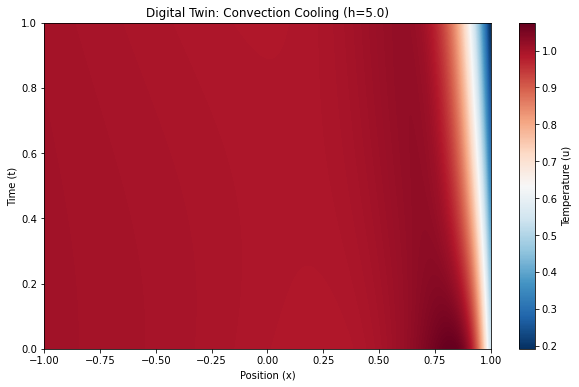

Saved convection_heatmap.png


In [7]:
# ==========================================
# 5. VISUALIZATION & SAVING
# ==========================================

# Setup Grid for Heatmap
x = np.linspace(-1, 1, 200)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)
X_tensor = torch.tensor(X.flatten()[:, None], dtype=torch.float32)
T_tensor = torch.tensor(T.flatten()[:, None], dtype=torch.float32)

model.eval()
with torch.no_grad():
    U_pred = model(X_tensor, T_tensor).numpy().reshape(X.shape)

# --- PLOT 1: The Heatmap ---
plt.figure(figsize=(10, 6))
plt.imshow(U_pred, interpolation='bicubic', cmap='RdBu_r', 
           extent=[x.min(), x.max(), t.min(), t.max()], 
           origin='lower', aspect='auto')
plt.colorbar(label='Temperature (u)')
plt.xlabel('Position (x)')
plt.ylabel('Time (t)')
plt.title(f'Digital Twin: Convection Cooling (h={H_COEFF})')
plt.savefig('convection_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved convection_heatmap.png")

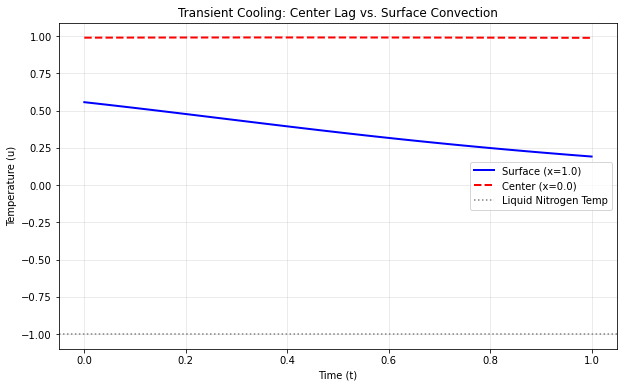

Saved cooling_curves.png


In [8]:
# --- PLOT 2: Cooling Curves (Surface vs Center) ---
plt.figure(figsize=(10, 6))

# Prepare 1D Time Vector
t_val = np.linspace(0, 1, 100)
t_vec = torch.tensor(t_val[:, None], dtype=torch.float32)

# Predict Surface (x=1)
x_surf = torch.ones_like(t_vec) * 1.0
with torch.no_grad():
    u_surf_pred = model(x_surf, t_vec).numpy()

# Predict Center (x=0)
x_center = torch.zeros_like(t_vec)
with torch.no_grad():
    u_center_pred = model(x_center, t_vec).numpy()

plt.plot(t_val, u_surf_pred, 'b-', linewidth=2, label='Surface (x=1.0)')
plt.plot(t_val, u_center_pred, 'r--', linewidth=2, label='Center (x=0.0)')
plt.axhline(y=T_INF, color='gray', linestyle=':', label='Liquid Nitrogen Temp')

plt.xlabel('Time (t)')
plt.ylabel('Temperature (u)')
plt.title('Transient Cooling: Center Lag vs. Surface Convection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('cooling_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved cooling_curves.png")